#Ramdom Forest#

En la parte anterior se realizaron pronosticos desde el primero de enero de 2015, hasta el 22 de mayo de 2016, para cada referencia, 455 dias pertenecientes al periodo de entrenamiento (Entre los dias 1434 a 1889), 24 días para el periodo de validación(1890 a 1913) y 28 dias del periodo de prueba (1914 a 1941). La idea es poder calcular el vector de errores (predichos-observados) para usarlo como variable objetivo en el modelo de random forest, y tratar de explicar estos errores con la matriz de covariables de eventos y precios, para luego poder generar predicciones de estos errores para los 28 dias siguientes y finalmente poder sumar las predicciones del LSTM (basada unicamente en la informacion de las ventas, o sea la serie de tiempo) y la prediccion de los errores, es decir la diferencia entre las predicciones del LSTM y los valores reales no explicada por la serie de tiempo.

In [3]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
register_matplotlib_converters()
sns.set()

In [0]:
sales = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/sales_train_validation.csv')#Continene los datos historicos de la venta diaria de cada uno de los productos
cal = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/calendar.csv')#Contiene información de días en los que se llevaron a cabo promociones y campañas
prices = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/sell_prices.csv')# Contiene información del precio de los productos por dia y por tienda
submission = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/sample_submission.csv') #Ejemplo del archivo que hay que mandar

#Cargamos las predicciones realizadas por el LSTM en la parte 1.

pred_LSTM_ene15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Enero2015.csv')
pred_LSTM_feb15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Febrero2015.csv')
pred_LSTM_mar15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Marzo2015.csv')
pred_LSTM_abril15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Abril2015.csv')
pred_LSTM_mayo15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Mayo2015.csv')
pred_LSTM_jun15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Junio2015.csv')
pred_LSTM_jul15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Julio2015.csv')
pred_LSTM_ago15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Agosto2015.csv')
pred_LSTM_sept15= pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Septiembre2015.csv')
pred_LSTM_oct15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Octubre2015.csv')
pred_LSTM_nov15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Noviembre2015.csv')
pred_LSTM_dic15 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Diciembre2015.csv')
pred_LSTM_ene16 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Enero2016.csv')
pred_LSTM_feb16 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Febrero2016.csv')
pred_LSTM_mar16 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_Marzo2016.csv')
pred_LSTM_val = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_val.csv')
pred_LSTM_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_test.csv')

In [0]:
#Retiramos los datos de ventas anteriores al 2015.

sales.drop(sales.columns[6:1439], axis=1, inplace=True)# 1433 + 6

In [5]:
sales.shape

(30490, 486)

In [0]:
#Concatenamos los dataframes de predicciones que serán usados para calcular el vector de errores de entrenamiento y validación.
pred = pd.concat([pred_LSTM_ene15, pred_LSTM_feb15, pred_LSTM_mar15, pred_LSTM_abril15, pred_LSTM_mayo15, pred_LSTM_jun15, pred_LSTM_jul15, 
                  pred_LSTM_ago15, pred_LSTM_sept15, pred_LSTM_oct15, pred_LSTM_nov15, pred_LSTM_dic15, pred_LSTM_ene16, pred_LSTM_feb16, pred_LSTM_mar16, pred_LSTM_val], axis=1, sort=False)

In [0]:
ids = pred.iloc[:,:1]

In [8]:
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [0]:
pred = pred.drop(['id'], axis = 1)

In [0]:
pred = pd.concat([ids, pred], axis = 1, sort = False)

In [11]:
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#Filtrar para referencia, categoria, estado, tienda, etc

#sales= sales[sales.id.isin(['FOODS_3_001_CA_1_validation'])]
sales = sales[sales.store_id.isin(['CA_3'])]
sales = sales[sales.cat_id.isin(['FOODS'])]
prices = prices[prices.store_id.str.contains('CA_3')]
prices = prices[prices.item_id.str.contains('FOODS')]
#pred= pred[pred.id.isin(['FOODS_3_001_CA_1_validation'])]
pred = pred[pred.id.str.contains('CA_3')]
pred = pred[pred.id.str.contains('FOODS')]
pred = pred[pred.id.str.contains('validation')]
#submission= submission[submission.id.isin(['FOODS_3_001_CA_1_validation'])]
submission = submission[submission.id.str.contains('CA_3')]
submission = submission[submission.id.str.contains('FOODS')]
submission = submission[submission.id.str.contains('validation')]

In [0]:
#pred = pred[~pred['id'].str.endswith('_evaluation')]
pred = pred.melt(id_vars=["id"], var_name="F", value_name="Forecast")
#pred_LSTM_test = pred_LSTM_test[~pred_LSTM_test['id'].str.endswith('_evaluation')]
#pred_LSTM_test = pred_LSTM_test.melt(id_vars=["id_F"], var_name="F", value_name="Forecast")

In [14]:
print(pred.shape)
print(pred.head())

(689760, 3)
                            id   F  Forecast
0  FOODS_1_001_CA_3_validation  F1  0.771167
1  FOODS_1_002_CA_3_validation  F1  0.425151
2  FOODS_1_003_CA_3_validation  F1  0.983110
3  FOODS_1_004_CA_3_validation  F1  4.877383
4  FOODS_1_005_CA_3_validation  F1  1.404063


##Definicion de varias funciones##

In [15]:
#HOY
#Creamos un vector booleano cuyo valor será 1 o 0 dependiendo si hay evento o no en el día (t)
hoyEvento = []
for i in cal['event_name_1']:
  if pd.isna(i) == True:
    hoyEvento.append("0")
  else:
    hoyEvento.append("1")

# MAÑANA
#se crea un vector booleano empezando desde t+1, será 1 si hay evento en t+1 o 0 en caso de que no.
diaAnteriorEvento = []
for i in cal['event_name_1'][1:len(cal)]:
  if pd.isna(i) == True:
    diaAnteriorEvento.append("0")
  else:
    diaAnteriorEvento.append("1")

diaAnteriorEvento.append("0") 

#Este ultimo es para igualar el largo de las filas del DF Calendar. Recordar que el ciclo comenzó en el segundo elemento -->[1:len(calendar)]. Asumimos que para el ultimo día registrado en Calendar, el dia que le sigue no hubo evento. 
# PASADO MAÑANA
diaAnterior2Evento = []
for i in cal['event_name_1'][2:len(cal)]:
  if pd.isna(i) == True:
    diaAnterior2Evento.append("0")
  else:
    diaAnterior2Evento.append("1")

diaAnterior2Evento.append("0") 
diaAnterior2Evento.append("0")

len(hoyEvento)

1969

In [0]:
#Se agregan las nuevas variables de eventos al calendario 
cal["EventoHoy"]=hoyEvento
cal["EventoMañana"]=diaAnteriorEvento
cal["EventoPasadoMañana"]=diaAnterior2Evento
Doomies_Event_Type=pd.get_dummies(cal["event_type_1"])
Doomies_Event_Type.rename(columns={'Cultural':'event_type_Bool_Cultural'}, inplace=True)
Doomies_Event_Type.rename(columns={'National':'event_type_Bool_National'}, inplace=True)
Doomies_Event_Type.rename(columns={'Religious':'event_type_Bool_Religious'}, inplace=True)
Doomies_Event_Type.rename(columns={'Sporting':'event_type_Bool_Sporting'}, inplace=True)
Doomies_Event_Type

In [18]:
# Se concatenan las doomies creadas y la tabla de calendario
cal = pd.concat([cal, Doomies_Event_Type], axis=1, sort=False)
cal

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,EventoHoy,EventoMañana,EventoPasadoMañana,event_type_Bool_Cultural,event_type_Bool_National,event_type_Bool_Religious,event_type_Bool_Sporting
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0,0,0,0,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,0,0,0,0,0,0,0
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0


In [0]:
# Es importante saber si el hecho de que sea un día en particular de la semana, numero de día del mes, semana del año, mes, trimestre o año tiene
# relevancia en las predicciones. Por lo tanto se define una funcion para hacerlo.

def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])

    attrs = [
        "quarter",
        #"week",
        #"year",
        #"day",
        #"month",
        #"dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["is_weekend"] = df["wday"].isin([1, 2]).astype(np.int8)
    return df

In [0]:
cal = add_time_features(cal, "date")

In [21]:
cal["month"].replace({1: "01_January", 2: "02_February", 3: "03_March", 4: "04_April", 5: "05_May", 6: "06_June", 7: "07_July",8: "08_August",9: "09_September",10: "10_October",11: "11_November",12: "12_December"}, inplace=True)
cal["quarter"].replace({1: "quarter_1", 2: "quarter_2", 3: "quarter_3", 4: "quarter_4"}, inplace=True)
#cal["week"].replace({1: "week_01", 2: "week_02", 3: "week_03", 4: "week_04", 5: "week_05", 6: "week_06", 7: "week_07", 8: "week_08",9: "week_09",10: "week_10",11: "week_11", 12: "week_12", 13: "week_13", 14: "week_14", 15: "week_15", 16: "week_16", 17: "week_17", 18: "week_18",19: "week_19",20: "week_20",21: "week_21", 22: "week_22", 23: "week_23", 24: "week_24", 25: "week_25", 26: "week_26", 27: "week_27", 28: "week_28",29: "week_29",30: "week_30",31: "week_31", 32: "week_32", 33: "week_33", 34: "week_34", 35: "week_35", 36: "week_36", 37: "week_37", 38: "week_38",39: "week_39",40: "week_40",41: "week_41", 42: "week_42", 43: "week_43", 44: "week_44", 45: "week_45", 46: "week_46", 47: "week_47", 48: "week_48",49: "week_49",50: "week_50",51: "week_51", 52: "week_52", 53: "week_53"}, inplace=True)
#cal["day"].replace({1: "day_month_01", 2: "day_month_02", 3: "day_month_03", 4: "day_month_04", 5: "day_month_05", 6: "day_month_06", 7: "day_month_07", 8: "day_month_08",9: "day_month_09",10: "day_month_10",11: "day_month_11", 12: "day_month_12", 13: "day_month_13", 14: "day_month_14", 15: "day_month_15", 16: "day_month_16", 17: "day_month_17", 18: "day_month_18",19: "day_month_19",20: "day_month_20",21: "day_month_21", 22: "day_month_22", 23: "day_month_23", 24: "day_month_24", 25: "day_month_25", 26: "day_month_26", 27: "day_month_27", 28: "day_month_28",29: "day_month_29",30: "day_month_30",31: "day_month_31"}, inplace=True)
cal["year"].replace({2011: "year_2011", 2012: "year_2012", 2013: "year_2013", 2014: "year_2014", 2015: "year_2015",2016: "year_2016"}, inplace=True)
cal["weekday"].replace({"Monday": "01_Monday", "Tuesday": "02_Tuesday", "Wednesday": "03_Wednesday", "Thursday": "04_Thursday", "Friday": "05_Friday", "Saturday": "06_Saturday", "Sunday": "07_Sunday"}, inplace=True)

Doomies_weekday=pd.get_dummies(cal["weekday"])
Doomies_month=pd.get_dummies(cal["month"])
Doomies_year=pd.get_dummies(cal["year"])
#Doomies_week=pd.get_dummies(cal["week"])
Doomies_quarter=pd.get_dummies(cal["quarter"])
#Doomies_day=pd.get_dummies(cal["day"])

calendar = cal[{"date","wm_yr_wk"}]
calendar = pd.concat([calendar,cal.d], axis=1, sort=False)
calendar = pd.concat([calendar, Doomies_year], axis=1, sort=False)
calendar = pd.concat([calendar, Doomies_quarter], axis=1, sort=False)
calendar = pd.concat([calendar, Doomies_month], axis=1, sort=False)
#calendar = pd.concat([calendar, Doomies_week], axis=1, sort=False)
#calendar = pd.concat([calendar, Doomies_day], axis=1, sort=False)
calendar = pd.concat([calendar, Doomies_weekday], axis=1, sort=False)
calendar = pd.concat([calendar, cal.is_weekend, cal.EventoHoy, cal.EventoMañana, cal.EventoPasadoMañana, cal.event_type_Bool_Cultural, cal.event_type_Bool_National, cal.event_type_Bool_Religious, cal.event_type_Bool_Sporting, cal.snap_CA], axis=1, sort=False)
calendar

,date,wm_yr_wk,d,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,quarter_1,quarter_2,quarter_3,quarter_4,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,01_Monday,02_Tuesday,03_Wednesday,04_Thursday,05_Friday,06_Saturday,07_Sunday,is_weekend,EventoHoy,EventoMañana,EventoPasadoMañana,event_type_Bool_Cultural,event_type_Bool_National,event_type_Bool_Religious,event_type_Bool_Sporting,snap_CA
0,2011-01-29,11101,d_1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,2011-01-30,11101,d_2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,2011-01-31,11101,d_3,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2011-02-01,11101,d_4,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2011-02-02,11101,d_5,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,d_1965,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1965,2016-06-16,11620,d_1966,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1966,2016-06-17,11620,d_1967,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
1967,2016-06-18,11621,d_1968,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0


In [0]:
import IPython

def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df) #Para desplegar varios DF.

In [0]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [0]:
def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16) # Función para extraer el numero del día de las columna (d_1 ->1 // d_13 -> 13)


def reshape_sales(sales, submission, d_thresh=0, verbose=True):
    # Encabezados a los que se le aplicará método melt.
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

    # Dejar tabla sin la demanda de los días (Vamos a poner los días en fila y no columna.)
    product = sales[id_columns]

    
    sales = sales.melt(id_vars=id_columns, var_name="d", value_name="demand",)# Construir tabla con función melt para que la demanda me quede en función de los días en fila. 
    sales = reduce_mem_usage(sales) #Con esto me vuelve a quedar los días en columna 

    # Separar el DataFrame "Submission" en validación y evaluación. 
    vals = submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    # Editar nombre de las columnas de los días para que quede acorde con lo que serán el reango de los días de predicción y el rango de los días de validación.
    vals.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    # Unir tabla de validación y evaluación con la tabla de producto (item_id;dept_id;cat_id;store_id;state_id)
    evals["id"] = evals["id"].str.replace("_evaluation", "_validation")
    vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    evals["id"] = evals["id"].str.replace("_validation", "_evaluation")


    #Impresión de tablas finales de validación y evaluación.
    if verbose:
        print("validation")
        display(vals)

        print("evaluation")
        display(evals)

    #Llevar estructura de la tabla de validación y evaluación a que los días esten en fila (La anterior la compusimos como lo pide submission que es los días en columna)
    vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    #Agregar columna "part" para indicar si el dato corresponde a el dataset de entrenamiento, el de validación o el de evaluación. 
    sales["part"] = "train"
    vals["part"] = "validation"
    evals["part"] = "evaluation"

    #Unir todo en un solo dataset llamdo "data"
    data = pd.concat([sales, vals, evals], axis=0)

    #Eliminar los demas DF que ya se utilizaron para componer el DF data (Por memoria)
    del sales, vals, evals


    data["d"] = extract_num(data["d"])
    data = data[data["d"] >= d_thresh]

    # Elimianar DF "evals" de data (Por el momento)
    data = data[data["part"] != "evaluation"]

    gc.collect() #Garbage Colector

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar):
    #calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1) #Quitar Columnas "weekday", "wday", "month", "year" de Calendar // Despues se la añadiran con otros datos mas enriquecidos en la función add_time_features 
    return data.merge(calendar, how="left", on="d") #Unir tabla "data" con "calendar" a partir de la columna "d" (La que indica el día)


def merge_prices(data, prices):
    return data.merge(prices, how="left", on=["store_id", "item_id", "wm_yr_wk"]) #Unir tabla "data" con "prices" a partir de la correspondencia de las columnas "store_id", "item_id", "wm_yr_wk"

In [0]:
def add_price_features(df):
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    #df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        #df["shift_price_t1"]
    #)
    #df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        #lambda x: x.shift(1).rolling(365).max()
    #)
    #df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        #df["rolling_price_max_t365"]
    #)

    #df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        #lambda x: x.rolling(7).std()
    #)
    #df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        #lambda x: x.rolling(30).std()
    #)
    return df.drop(["shift_price_t1"], axis=1)

In [0]:
NUM_ITEMS = 30490  # 30490
DAYS_PRED = 28  # 28

In [27]:
calendar.head()

,date,wm_yr_wk,d,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,quarter_1,quarter_2,quarter_3,quarter_4,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,01_Monday,02_Tuesday,03_Wednesday,04_Thursday,05_Friday,06_Saturday,07_Sunday,is_weekend,EventoHoy,EventoMañana,EventoPasadoMañana,event_type_Bool_Cultural,event_type_Bool_National,event_type_Bool_Religious,event_type_Bool_Sporting,snap_CA
0,2011-01-29,11101,d_1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
1,2011-01-30,11101,d_2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,2011-01-31,11101,d_3,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2011-02-01,11101,d_4,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2011-02-02,11101,d_5,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [28]:
data = reshape_sales(sales, submission, d_thresh=0)
del sales
gc.collect()

calendar["d"] = extract_num(calendar["d"]) # Extraer el numero del día de las columna (d_1 ->1 // d_13 -> 13).
data = merge_calendar(data, calendar) # Unir Dataframe de "calendar" con "data" con la función merge_calendar
del calendar 
gc.collect()

data = merge_prices(data, prices)# Unir Dataframe de "calendar" con "data" con la función merge_calendar
del prices
gc.collect()

data = reduce_mem_usage(data)

validation


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FOODS_1_001,FOODS_1,FOODS,CA_3,CA
1,FOODS_1_002_CA_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FOODS_1_002,FOODS_1,FOODS,CA_3,CA
2,FOODS_1_003_CA_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FOODS_1_003,FOODS_1,FOODS,CA_3,CA
3,FOODS_1_004_CA_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FOODS_1_004,FOODS_1,FOODS,CA_3,CA
4,FOODS_1_005_CA_3_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FOODS_1_005,FOODS_1,FOODS,CA_3,CA


evaluation


,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,d_1951,d_1952,d_1953,d_1954,d_1955,d_1956,d_1957,d_1958,d_1959,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969,id,item_id,dept_id,cat_id,store_id,state_id


data


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part
0,FOODS_1_001_CA_3_validation,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,1434,0,train
1,FOODS_1_002_CA_3_validation,FOODS_1_002,FOODS_1,FOODS,CA_3,CA,1434,0,train
2,FOODS_1_003_CA_3_validation,FOODS_1_003,FOODS_1,FOODS,CA_3,CA,1434,0,train
3,FOODS_1_004_CA_3_validation,FOODS_1_004,FOODS_1,FOODS,CA_3,CA,1434,8,train
4,FOODS_1_005_CA_3_validation,FOODS_1_005,FOODS_1,FOODS,CA_3,CA,1434,0,train


In [29]:
data = add_price_features(data).pipe(reduce_mem_usage)
dt_col = "date"
#data = add_time_features(data, dt_col).pipe(reduce_mem_usage)
#data = data.sort_values("date")

print("start date:", data[dt_col].min())
print("end date:", data[dt_col].max())
print("data shape:", data.shape)

start date: 2015-01-01 00:00:00
end date: 2016-05-22 00:00:00
data shape: (729996, 50)


In [0]:
#Importación de librerías necesarias
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

# A continuación se genera un codigo numérico para las variables: "item_id", "dept_id", "cat_id", "store_id","state_id"
from sklearn import preprocessing, metrics
def encode_categorical(df, cols):
    for col in cols:
        # Leave NaN as it is.
        le = preprocessing.LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)
    return df
data = encode_categorical(data, ["item_id", "dept_id", "cat_id", "store_id","state_id",'wm_yr_wk'])
#A continuación se eliminan columnas que no van a ser utilizadas en el modelo
data=data.drop(columns=['d'])

In [0]:
data = data.fillna(0)

In [32]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,quarter_1,quarter_2,quarter_3,quarter_4,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,01_Monday,02_Tuesday,03_Wednesday,04_Thursday,05_Friday,06_Saturday,07_Sunday,is_weekend,EventoHoy,EventoMañana,EventoPasadoMañana,event_type_Bool_Cultural,event_type_Bool_National,event_type_Bool_Religious,event_type_Bool_Sporting,snap_CA,sell_price
0,FOODS_1_001_CA_3_validation,0,0,0,0,0,0,train,2015-01-01,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,2.24
1,FOODS_1_002_CA_3_validation,1,0,0,0,0,0,train,2015-01-01,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,9.48
2,FOODS_1_003_CA_3_validation,2,0,0,0,0,0,train,2015-01-01,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,2.88
3,FOODS_1_004_CA_3_validation,3,0,0,0,0,8,train,2015-01-01,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1.96
4,FOODS_1_005_CA_3_validation,4,0,0,0,0,0,train,2015-01-01,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,3.54


In [0]:
data_train_val = data[data['date'] <= '2016-04-24']

In [34]:
data_train_val.shape

(689760, 49)

In [0]:
data_train_val["error"] = data_train_val["demand"] - pred["Forecast"]

In [0]:
x_train = data_train_val[data_train_val['date'] <= '2016-03-31']
y_train = x_train['error']
#Se definen los datos de Validación
x_val = data_train_val[(data_train_val['date'] > '2016-03-31') & (data_train_val['date'] <= '2016-04-24')]
y_val = x_val['error']
dias_val=x_val['date']

#Se definen los datos de testeo
test = data[(data['date'] > '2016-04-24')]

#A continuación se elimina la columna demanda y fecha
x_train=x_train.drop(columns=['date','demand','id','part', 'error'])
x_val=x_val.drop(columns=['date','demand','id','part','error'])
X_test = test.drop(columns=['date','demand','id','part'])

In [38]:
print(test.shape)
print(dias_val.shape)
print(x_val.shape)

(40236, 49)
(34488,)
(34488, 45)


In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
x_train = sc.fit_transform(x_train)
#y_train = sc.fit_transform(y_train)
x_val = sc.fit_transform(x_val)
#y_val = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_train)

In [0]:
#x_train = np.array(x_train)
#y_train = np.array(y_train)

In [0]:
# Se genera el modelo random forest base con los parámetros que vienen por defecto en la librería
#ModelRF_base = RandomForestRegressor(random_state=123).fit(x_train, y_train)

# Predicción 
#y_pred=ModelRF_base.predict(x_val)

In [0]:
#y_pred = sc.inverse_transform(y_pred)

In [0]:
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    #print "Needs to be tested."
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [0]:
#A continuación se lleva a cabo una evaluación por medio de las métricas de Accurancy y MSE para éste primer modelo

#A continuación se lleva a cabo una evaluación por medio de las métricas de Accurancy y MSE para éste primer modelo

#Evaluación del Accuracy
#ModelRF_base_Score = ModelRF_base.score(x_val, y_val)

#Evaluación de MSE
#ModelRF_base_MSE= mean_squared_error(y_val, y_pred)

#Evaluación de MASE
#ModelRF_base_MASE = MASE(y_train, y_val, y_pred)

#Imprimen los resultados
#print('Random Forest Accuracy: {}'.format(ModelRF_base_Score))
#print('Random Forest MSE: {}'.format(ModelRF_base_MSE))
#print('Random Forest MASE: {}'.format(ModelRF_base_MASE))#

In [0]:
#y_val

In [0]:
#ModelRF_base.feature_importances_
#imp_feat=pd.Series(ModelRF_base.feature_importances_,index=x_train.columns.tolist())
#imp_feat.sort_values(ascending=False)

In [0]:
#A continuación se limitan los datos de entrenamiento sólo a las variables mas importantes

#features = imp_feat[imp_feat >= 0.001] 

# Se ajustan los datos de entrenamiento solo con las variables seleccionadas

#x_train=x_train[features.index]
#x_val=x_val[features.index]
#X_test=X_test[features.index]

In [0]:
#Se define función para evaluar rendimiento de los modelos
from sklearn.metrics import mean_squared_error, r2_score

def evaluate(model, x_val, y_val):
    y_pred=model.predict(x_val)
    MSE = mean_squared_error(y_val, y_pred)
    r2 =  r2_score(y_val, y_pred)
    mase = MASE(y_train, y_val, y_pred)

    print('Rendimiento del modelo')
    print('Random Forest MSE: {}'.format(MSE))
    print('Random Forest R^2: {}'.format(r2))
    print('Random Forest MASE: {}'.format(mase))

## Optimización de parámetros (Random Grid)

In [0]:
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import pprint
#from scipy.stats import randint as sp_randint
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import r2_score

# Se definen los parámetros para realizar el random search
#param_dist = {"max_depth": [3, 10],
              #"max_features": sp_randint(1, 15),
              #"min_samples_split": sp_randint(2, 11),
              #"min_samples_leaf": sp_randint(1, 11),
              #"bootstrap": [True, False],
              #"n_estimators": sp_randint(20, 80)}

#n_iter_search = 50
#random_search = RandomizedSearchCV(ModelRF_base, param_distributions=param_dist,n_iter=n_iter_search,scoring='neg_mean_squared_error')

In [0]:
# Se ejecuta el modelo de random search
#ModelRF_Random_Search=random_search.fit(x_train,y_train)
#Se muestran los mejores resultados para cada parámetro
#print('Best depth:',ModelRF_Random_Search.best_estimator_.max_depth)
#print('Best n trees:',ModelRF_Random_Search.best_estimator_.n_estimators)
#print('Best n features:',ModelRF_Random_Search.best_estimator_.max_features)
#print('Best n min samples split:',ModelRF_Random_Search.best_estimator_.min_samples_split)
#print('Best n min samples leaf:',ModelRF_Random_Search.best_estimator_.min_samples_leaf)
#print('Bootstrap?:',ModelRF_Random_Search.best_estimator_.bootstrap)
#print(evaluate(ModelRF_Random_Search,x_val,y_val))
#print("Mejores Parámetros: " + str(ModelRF_Random_Search.best_params_))

In [51]:
ModelRF_final = RandomForestRegressor(bootstrap=True,max_depth=10,max_features=9,min_samples_split=2,
                                      min_samples_leaf=1,n_estimators=75,random_state=123).fit(x_train,y_train)

# Validación
y_pred=ModelRF_final.predict(x_val)

evaluate(ModelRF_final,x_val,y_val)

Rendimiento del modelo
Random Forest MSE: 15.106643907551929
Random Forest R^2: 0.059377968741638476
Random Forest MASE: 0.6162084417101158


Text(0.5, 1.0, 'Predicción vs Actual')

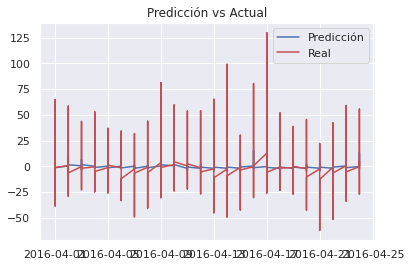

In [54]:
import matplotlib.pyplot as plt
plt.plot(dias_val, y_pred,'b', label='Predicción',)
plt.plot(dias_val, y_val,'r', label='Real',)
plt.legend()
plt.title("Predicción vs Actual")

In [0]:
y_pred_final=ModelRF_final.predict(X_test)

In [0]:
test['errores'] = y_pred_final

In [790]:
test

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,quarter_1,quarter_2,quarter_3,quarter_4,01_January,02_February,03_March,04_April,05_May,06_June,07_July,08_August,09_September,10_October,11_November,12_December,01_Monday,02_Tuesday,03_Wednesday,04_Thursday,05_Friday,06_Saturday,07_Sunday,is_weekend,EventoHoy,EventoMañana,EventoPasadoMañana,event_type_Bool_Cultural,event_type_Bool_National,event_type_Bool_Religious,event_type_Bool_Sporting,sell_price,errores
502560,HOUSEHOLD_1_001_WI_3_validation,0,0,0,0,0,0,validation,2016-04-25,69,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.970000,-0.081334
502561,HOUSEHOLD_1_002_WI_3_validation,1,0,0,0,0,0,validation,2016-04-25,69,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.970000,-0.038624
502562,HOUSEHOLD_1_003_WI_3_validation,2,0,0,0,0,0,validation,2016-04-25,69,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.970000,-0.038624
502563,HOUSEHOLD_1_004_WI_3_validation,3,0,0,0,0,0,validation,2016-04-25,69,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.360000,-0.038624
502564,HOUSEHOLD_1_005_WI_3_validation,4,0,0,0,0,0,validation,2016-04-25,69,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.970000,-0.038624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531871,HOUSEHOLD_2_512_WI_3_validation,1042,1,0,0,0,0,validation,2016-05-22,73,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,3.970000,0.084666
531872,HOUSEHOLD_2_513_WI_3_validation,1043,1,0,0,0,0,validation,2016-05-22,73,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,2.780000,0.084666
531873,HOUSEHOLD_2_514_WI_3_validation,1044,1,0,0,0,0,validation,2016-05-22,73,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,19.540001,0.084666
531874,HOUSEHOLD_2_515_WI_3_validation,1045,1,0,0,0,0,validation,2016-05-22,73,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1.970000,0.084666


In [0]:
from google.colab import files
predictions = test[['id', 'date', 'errores']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'errores').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.to_csv('errores.csv', index = False)
#files.download('submission.csv')


In [792]:
final

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOUSEHOLD_1_001_WI_3_validation,-0.081334,-0.053006,-0.002271,0.115391,0.241212,0.343495,0.262592,-0.022077,0.038674,-0.043419,-0.003029,0.129188,0.299024,0.254154,-0.022077,-0.015098,-0.023173,0.036236,0.137937,0.298733,0.250231,-0.022077,-0.015098,-0.023173,0.036236,0.137937,0.298733,0.250231
1,HOUSEHOLD_1_002_WI_3_validation,-0.038624,-0.209233,-0.028615,-0.021629,0.121841,0.433878,0.097846,0.006055,-0.015638,-0.300009,-0.065450,0.140788,0.452087,0.338295,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378
2,HOUSEHOLD_1_003_WI_3_validation,-0.038624,-0.209233,-0.028615,-0.021629,0.121841,0.433878,0.097846,0.006055,-0.015638,-0.300009,-0.065450,0.140788,0.452087,0.338295,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378
3,HOUSEHOLD_1_004_WI_3_validation,-0.038624,-0.209233,-0.028615,-0.021629,0.121841,0.433878,0.097846,0.006055,-0.015638,-0.300009,-0.065450,0.140788,0.452087,0.338295,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378
4,HOUSEHOLD_1_005_WI_3_validation,-0.038624,-0.209233,-0.028615,-0.021629,0.121841,0.433878,0.097846,0.006055,-0.015638,-0.300009,-0.065450,0.140788,0.452087,0.338295,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378,0.006055,-0.052194,-0.278382,-0.024626,0.090583,0.447479,0.135378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,HOUSEHOLD_2_512_WI_3_validation,-0.004535,-0.024995,-0.001022,0.018646,0.071601,0.075314,0.059138,-0.014183,0.003091,-0.016435,-0.004481,0.055527,0.086728,0.097274,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666
1043,HOUSEHOLD_2_513_WI_3_validation,-0.004535,-0.024995,-0.001022,0.018646,0.071601,0.075314,0.059138,-0.014183,0.003091,-0.016435,-0.004481,0.055527,0.086728,0.097274,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666
1044,HOUSEHOLD_2_514_WI_3_validation,-0.004535,-0.024995,-0.001022,0.018646,0.071601,0.075314,0.059138,-0.014183,0.003091,-0.016435,-0.004481,0.055527,0.086728,0.097274,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666
1045,HOUSEHOLD_2_515_WI_3_validation,-0.004535,-0.024995,-0.001022,0.018646,0.071601,0.075314,0.059138,-0.014183,0.003091,-0.016435,-0.004481,0.055527,0.086728,0.097274,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666,-0.014183,-0.022601,-0.014823,-0.005135,0.047252,0.065246,0.084666


#SUMAR PREDICCIONES LSTM + RANDOM FOREST

In [0]:
pred_LSTM_28d = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Proyecto Integrador/Pred_LSTM_test.csv')

In [0]:
print(pred_LSTM_28d.head())
print(final.head())

In [0]:
print(pred_LSTM_28d.shape)
print(final.shape)
print(pred_LSTM_28d.info())
print(final.info())
#print(pred_LSTM_final)

In [0]:
Pred_final_LSTM_RF = pred_LSTM_28d + final

In [0]:
Pred_final_LSTM_RF.tail()

In [0]:
Pred_final_LSTM_RF["id"] = pred_LSTM_28d["id"]

In [0]:
Pred_final_LSTM_RF.tail()

In [0]:
Pred_values = Pred_final_LSTM_RF.iloc[:,1:29]
ids = Pred_final_LSTM_RF.iloc[:,:1]

In [0]:
print(ids.head())
print(Pred_values.head())

In [0]:
Pred_values[Pred_values < 0] = 0


In [0]:
Pred_values

In [0]:
Predicciones_final_LSTM_RF = pd.concat([ids,Pred_values], axis=1, sort=False)

In [0]:
Predicciones_final_LSTM_RF
Predicciones_final_LSTM_RF.to_csv('Try2_Predicciones_final_LSTM_RF.csv', index = False)